In [1]:
# 定义我们的 preprocess：将图片的数值介于 0~255 的 int 类性转为 0～1 的 float。
import numpy as np

def preprocess(image_list):
    """ Normalize Image and Permute (N,H,W,C) to (N,C,H,W)
    Args:
      image_list: List of images (9000, 32, 32, 3)
    Returns:
      image_list: List of images (9000, 3, 32, 32)
    """
    image_list = np.array(image_list)
    image_list = np.transpose(image_list, (0, 3, 1, 2))
    image_list = (image_list / 255.0) * 2 - 1
    image_list = image_list.astype(np.float32)
    return image_list

In [2]:
from torch.utils.data import Dataset

class Image_Dataset(Dataset):
    def __init__(self, image_list):
        self.image_list = image_list
    def __len__(self):
        return len(self.image_list)
    def __getitem__(self, idx):
        images = self.image_list[idx]
        return images

In [4]:
# 将训练资料读入，并且 preprocess。
# 之后我们将 preprocess 完的训练资料变成我们需要的 dataset。请同学不要使用 valX 和 valY 来训练。
from torch.utils.data import DataLoader

trainX = np.load('trainX.npy')
trainX_preprocessed = preprocess(trainX)
img_dataset = Image_Dataset(trainX_preprocessed)

# Some Useful Functions

In [6]:
import random
import torch

def count_parameters(model, only_trainable=False):
    if only_trainable:
        return sum(p.numel() for p in model.parameters() if p.requires_grad)
    else:
        return sum(p.numel() for p in model.parameters())

def same_seeds(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

# Model

In [7]:
import torch.nn as nn

class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 3, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2)
        )
 
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 5, stride=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 9, stride=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 17, stride=1),
            nn.Tanh()
        )

    def forward(self, x):
        x1 = self.encoder(x)
        x  = self.decoder(x1)
        return x1, x

这个部分就是主要的训练阶段。
我们先将准备好的 dataset 当作参数喂给 dataloader。
将 dataloader、model、loss criterion、optimizer 都准备好之后，就可以开始训练。
训练完成后，我们会将 model 存下来。

In [8]:
import torch
from torch import optim


model = AE().cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-5)

model.train()
n_epoch = 100

same_seeds(0)
# 准备 dataloader, model, loss criterion 和 optimizer
img_dataloader = DataLoader(img_dataset, batch_size=64, shuffle=True)


# 主要的训练过程
for epoch in range(n_epoch):
    for data in img_dataloader:
        img = data
        img = img.cuda()

        output1, output = model(img)
        loss = criterion(output, img)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (epoch+1) % 10 == 0:
            torch.save(model.state_dict(), './checkpoints/checkpoint_{}.pth'.format(epoch+1))
            
    print('epoch [{}/{}], loss:{:.5f}'.format(epoch+1, n_epoch, loss.data))

# 训练完成后储存 model
torch.save(model.state_dict(), './checkpoints/last_checkpoint.pth')

epoch [1/100], loss:0.20570
epoch [2/100], loss:0.16635
epoch [3/100], loss:0.14914
epoch [4/100], loss:0.12304
epoch [5/100], loss:0.11949
epoch [6/100], loss:0.11107
epoch [7/100], loss:0.11232
epoch [8/100], loss:0.09579
epoch [9/100], loss:0.09042
epoch [10/100], loss:0.09183
epoch [11/100], loss:0.10304
epoch [12/100], loss:0.09234
epoch [13/100], loss:0.09055
epoch [14/100], loss:0.08815
epoch [15/100], loss:0.08855
epoch [16/100], loss:0.08622
epoch [17/100], loss:0.07689
epoch [18/100], loss:0.08162
epoch [19/100], loss:0.08573
epoch [20/100], loss:0.08071
epoch [21/100], loss:0.09052
epoch [22/100], loss:0.07786
epoch [23/100], loss:0.08143
epoch [24/100], loss:0.08452
epoch [25/100], loss:0.06359
epoch [26/100], loss:0.06670
epoch [27/100], loss:0.07706
epoch [28/100], loss:0.07032
epoch [29/100], loss:0.06695
epoch [30/100], loss:0.07809
epoch [31/100], loss:0.06467
epoch [32/100], loss:0.07242
epoch [33/100], loss:0.06467
epoch [34/100], loss:0.07065
epoch [35/100], loss:0.

## Dimension Reduction & Clustering

In [9]:
import numpy as np

def cal_acc(gt, pred):
    """ Computes categorization accuracy of our task.
    Args:
      gt: Ground truth labels (9000, )
      pred: Predicted labels (9000, )
    Returns:
      acc: Accuracy (0~1 scalar)
    """
    # Calculate Correct predictions
    correct = np.sum(gt == pred)
    acc = correct / gt.shape[0]
    # 因为是 binary unsupervised clustering，因此取 max(acc, 1-acc)
    return max(acc, 1-acc)

In [10]:
import matplotlib.pyplot as plt

def plot_scatter(feat, label, savefig=None):
    """ Plot Scatter Image.
    Args:
      feat: the (x, y) coordinate of clustering result, shape: (9000, 2)
      label: ground truth label of image (0/1), shape: (9000,)
    Returns:
      None
    """
    X = feat[:, 0]
    Y = feat[:, 1]
    plt.scatter(X, Y, c = label)
    plt.legend(loc='best')
    if savefig is not None:
        plt.savefig(savefig)
    plt.show()
    return

接著我们使用训练好的 model，来预测 testing data 的类别。

由于 testing data 与 training data 一样，因此我们使用同样的 dataset 来实作 dataloader。与 training 不同的地方在于 shuffle 这个参数值在这边是 False。

准备好 model 与 dataloader，我们就可以进行预测了。

我们只需要 encoder 的结果（latents），利用 latents 进行 clustering 之后，就可以分类了。

In [11]:
import torch
from sklearn.decomposition import KernelPCA
from sklearn.manifold import TSNE
from sklearn.cluster import MiniBatchKMeans

def inference(X, model, batch_size=256):
    X = preprocess(X)
    dataset = Image_Dataset(X)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    latents = []
    for i, x in enumerate(dataloader):
        x = torch.FloatTensor(x)
        vec, img = model(x.cuda())
        if i == 0:
            latents = vec.view(img.size()[0], -1).cpu().detach().numpy()
        else:
            latents = np.concatenate((latents, vec.view(img.size()[0], -1).cpu().detach().numpy()), axis = 0)
    print('Latents Shape:', latents.shape)
    return latents

def predict(latents):
    # First Dimension Reduction
    transformer = KernelPCA(n_components=200, kernel='rbf', n_jobs=-1)
    kpca = transformer.fit_transform(latents)
    print('First Reduction Shape:', kpca.shape)

    # # Second Dimesnion Reduction
    X_embedded = TSNE(n_components=2).fit_transform(kpca)
    print('Second Reduction Shape:', X_embedded.shape)

    # Clustering
    pred = MiniBatchKMeans(n_clusters=2, random_state=0).fit(X_embedded)
    pred = [int(i) for i in pred.labels_]
    pred = np.array(pred)
    return pred, X_embedded

def invert(pred):
    return np.abs(1-pred)

def save_prediction(pred, out_csv='prediction.csv'):
    with open(out_csv, 'w') as f:
        f.write('id, label\n')
        for i, p in enumerate(pred):
            f.write(f'{i},{p}\n')
    print(f'Save prediction to {out_csv}.')

# load model
model = AE().cuda()
model.load_state_dict(torch.load('./checkpoints/last_checkpoint.pth'))
model.eval()

# 准备 data
trainX = np.load('trainX.npy')

# 預測答案
latents = inference(X=trainX, model=model)
pred, X_embedded = predict(latents)

# 将预测结果存档，上传 kaggle
save_prediction(pred, 'prediction.csv')

# 由于是 unsupervised 的二分类问题，我们只在乎有没有成功将图片分成两群
# 如果上面的档案上传 kaggle 后正确率不足 0.5，只要将 label 反过来就行了
save_prediction(invert(pred), 'prediction_invert.csv')

Latents Shape: (8500, 4096)
First Reduction Shape: (8500, 200)
Second Reduction Shape: (8500, 2)
Save prediction to prediction.csv.
Save prediction to prediction_invert.csv.


# Problem 1

将 val data 的降维结果 (embedding) 与他们对应的 label 画出来。

Latents Shape: (500, 4096)
First Reduction Shape: (500, 200)


No handles with labels found to put in legend.


Second Reduction Shape: (500, 2)
The clustering accuracy is: 0.782
The clustering result:


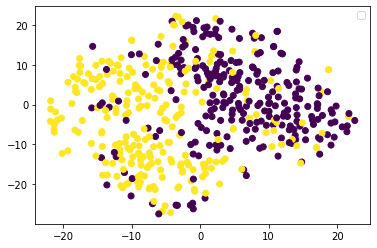

In [12]:
valX = np.load('valX.npy')
valY = np.load('valY.npy')

# ==============================================
#  我们示范 basline model 的作图，
#  report 请同学另外还要再画一张 improved model 的图。
# ==============================================
model.load_state_dict(torch.load('./checkpoints/last_checkpoint.pth'))
model.eval()
latents = inference(valX, model)
pred_from_latent, emb_from_latent = predict(latents)
acc_latent = cal_acc(valY, pred_from_latent)
print('The clustering accuracy is:', acc_latent)
print('The clustering result:')
plot_scatter(emb_from_latent, valY, savefig='p1_baseline.png')

# Problem 2

使用你 test accuracy 最高的 autoencoder，从 trainX 中，取出 index 1, 2, 3, 6, 7, 9 这 6 张图片
画出他们的原图以及 reconstruct 之后的图片。

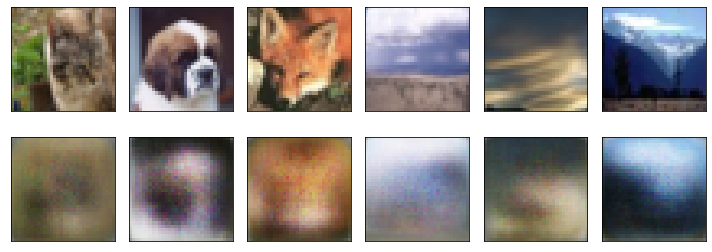

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# 画出原图
plt.figure(figsize=(10,4))
indexes = [1,2,3,6,7,9]
imgs = trainX[indexes,]
for i, img in enumerate(imgs):
    plt.subplot(2, 6, i+1, xticks=[], yticks=[])
    plt.imshow(img)

# 画出 reconstruct 的图
inp = torch.Tensor(trainX_preprocessed[indexes,]).cuda()
latents, recs = model(inp)
recs = ((recs+1)/2 ).cpu().detach().numpy()
recs = recs.transpose(0, 2, 3, 1)
for i, img in enumerate(recs):
    plt.subplot(2, 6, 6+i+1, xticks=[], yticks=[])
    plt.imshow(img)
  
plt.tight_layout()

# Problem 3

在 autoencoder 的训练过程中，至少挑选 10 个 checkpoints 
请用 model 的 train reconstruction error 对 val accuracy 作图
简单说明你观察到的现象

In [14]:
import glob
checkpoints_list = sorted(glob.glob('checkpoints/checkpoint_*.pth'))

# load data
dataset = Image_Dataset(trainX_preprocessed)
dataloader = DataLoader(dataset, batch_size=64, shuffle=False)

points = []
with torch.no_grad():
    for i, checkpoint in enumerate(checkpoints_list):
        print('[{}/{}] {}'.format(i+1, len(checkpoints_list), checkpoint))
        model.load_state_dict(torch.load(checkpoint))
        model.eval()
        err = 0
        n = 0
        for x in dataloader:
            x = x.cuda()
            _, rec = model(x)
            err += torch.nn.MSELoss(reduction='sum')(x, rec).item()
            n += x.flatten().size(0)
        print('Reconstruction error (MSE):', err/n)
        latents = inference(X=valX, model=model)
        pred, X_embedded = predict(latents)
        acc = cal_acc(valY, pred)
        print('Accuracy:', acc)
        points.append((err/n, acc))

[1/10] checkpoints/checkpoint_10.pth
Reconstruction error (MSE): 0.09323763925888959
Latents Shape: (500, 4096)
First Reduction Shape: (500, 200)
Second Reduction Shape: (500, 2)
Accuracy: 0.544
[2/10] checkpoints/checkpoint_100.pth
Reconstruction error (MSE): 0.04763634137546315
Latents Shape: (500, 4096)
First Reduction Shape: (500, 200)
Second Reduction Shape: (500, 2)
Accuracy: 0.734
[3/10] checkpoints/checkpoint_20.pth
Reconstruction error (MSE): 0.07780743651296579
Latents Shape: (500, 4096)
First Reduction Shape: (500, 200)
Second Reduction Shape: (500, 2)
Accuracy: 0.65
[4/10] checkpoints/checkpoint_30.pth
Reconstruction error (MSE): 0.06963621135786469
Latents Shape: (500, 4096)
First Reduction Shape: (500, 200)
Second Reduction Shape: (500, 2)
Accuracy: 0.692
[5/10] checkpoints/checkpoint_40.pth
Reconstruction error (MSE): 0.06398783515481388
Latents Shape: (500, 4096)
First Reduction Shape: (500, 200)
Second Reduction Shape: (500, 2)
Accuracy: 0.7
[6/10] checkpoints/checkpoi

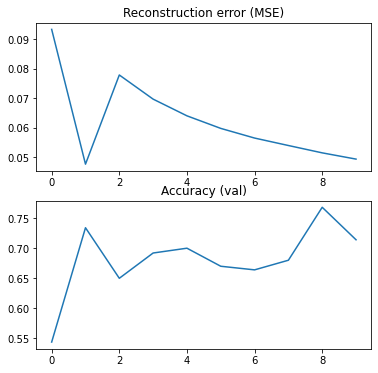

In [15]:
ps = list(zip(*points))
plt.figure(figsize=(6,6))
plt.subplot(211, title='Reconstruction error (MSE)').plot(ps[0])
plt.subplot(212, title='Accuracy (val)').plot(ps[1])
plt.show()